In [2]:
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity
import itertools
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go

In [4]:
stock_data = pd.read_csv('/content/stock_details_5_years.csv')

In [5]:
stock_data[0:458] #1 day

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA
...,...,...,...,...,...,...,...,...,...
453,2018-11-29 00:00:00-05:00,24.295910,24.311667,23.894130,24.161983,5671300,0.00,0.0,PPL
454,2018-11-29 00:00:00-05:00,22.307839,22.594573,22.152185,22.561804,6241100,0.00,0.0,FITB
455,2018-11-29 00:00:00-05:00,122.254275,123.960357,121.949627,123.237885,767600,0.00,0.0,IFF
456,2018-11-29 00:00:00-05:00,11.873100,11.931974,11.568912,11.706287,1494500,0.06,0.0,CCJ


<ipython-input-6-d8d96d4f2dae>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


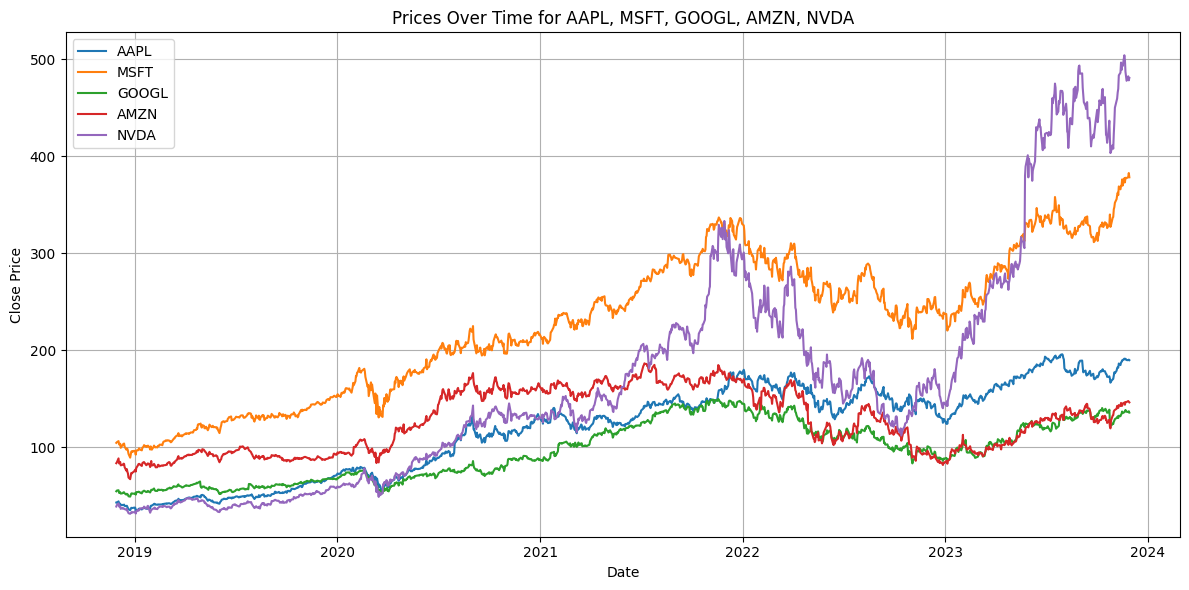

In [6]:
#Read + parse
stock_data = pd.read_csv('/content/stock_details_5_years.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

#Subset & pivot
tickers = ['AAPL','MSFT','GOOGL','AMZN','NVDA']
df5    = stock_data[stock_data['Company'].isin(tickers)]
pivot  = df5.pivot(index='Date', columns='Company', values='Close')

#Plot directly—Matplotlib handles DateTimeIndex natively
plt.figure(figsize=(12,6))
for tk in tickers:
    plt.plot(pivot.index, pivot[tk], label=tk)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prices Over Time for AAPL, MSFT, GOOGL, AMZN, NVDA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#Load & parse (force UTC then strip tz)
stock_data = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_convert(None)

#Pivot & returns
pivot_full   = stock_data.pivot(index='Date', columns='Company', values='Close')
returns_full = pivot_full.pct_change().iloc[1:].ffill()

#Params
tickers_full = returns_full.columns.tolist()
window_size, step, thresh = 60, 5, 0.7

#Get community assignments & end_dates
end_dates = []
comm_assignments = []
for start in range(0, len(returns_full) - window_size + 1, step):
    window  = returns_full.iloc[start : start + window_size]
    corr_mat = window.corr()

    G = nx.Graph()
    G.add_nodes_from(tickers_full)
    for i, j in itertools.combinations(tickers_full, 2):
        if corr_mat.loc[i, j] > thresh:
            G.add_edge(i, j, weight=corr_mat.loc[i, j])

    comms = list(greedy_modularity_communities(G, weight='weight'))
    top3  = sorted(comms, key=lambda c: len(c), reverse=True)[:3]

    ids = pd.Series(3, index=tickers_full)
    for idx, comm in enumerate(top3):
        ids[list(comm)] = idx

    end_dt = returns_full.index[start + window_size - 1]
    end_dates.append(end_dt)
    comm_assignments.append(ids)

comm_df = pd.DataFrame({dt: assign for dt, assign in zip(end_dates, comm_assignments)})

#Define your key anomaly windows
timeframes = [
    ('COVID Crash',  '2020-02-01', '2020-04-30'),
    ('Bull Market',  '2020-05-01', '2021-11-30'),
    ('2022 Correction','2021-12-01','2022-06-30'),
    ('Recovery 22-23','2022-07-01','2023-11-29'),
]

#Plot each sub‐period
for name, start_str, end_str in timeframes:
    #compare pure dates to avoid tz errors
    start_date = pd.to_datetime(start_str).date()
    end_date   = pd.to_datetime(end_str).date()

    #select only those window‐end timestamps whose date() is in range
    tf_dates = [d for d in end_dates
                if start_date <= d.date() <= end_date]
    if len(tf_dates) < 2:
        continue

    #build node labels
    labels = []
    for d in tf_dates:
        for cid in range(4):
            labels.append(f"{d.date()}_C{cid}")
    idx_map = {lab:i for i, lab in enumerate(labels)}

    #build links
    src, tgt, val = [], [], []
    for i in range(len(tf_dates)-1):
        d0, d1 = tf_dates[i], tf_dates[i+1]
        for c0 in range(4):
            for c1 in range(4):
                n = ((comm_df[d0] == c0) & (comm_df[d1] == c1)).sum()
                if n>0:
                    src.append(idx_map[f"{d0.date()}_C{c0}"])
                    tgt.append(idx_map[f"{d1.date()}_C{c1}"])
                    val.append(n)

    fig = go.Figure(go.Sankey(
        node=dict(label=labels),
        link=dict(source=src, target=tgt, value=val)
    ))
    fig.update_layout(title_text=f"Alluvial: {name}", font_size=10)
    fig.write_html(
    "Alluvial plot.html",
    include_plotlyjs="cdn",
    full_html=True
)
    fig.show()


            community_1_size  community_2_size  community_3_size
date                                                            
2019-02-28               118               107                42
2019-03-07               140                72                35
2019-03-14                93                88                74
2019-03-21                92                77                33
2019-03-28                64                58                23


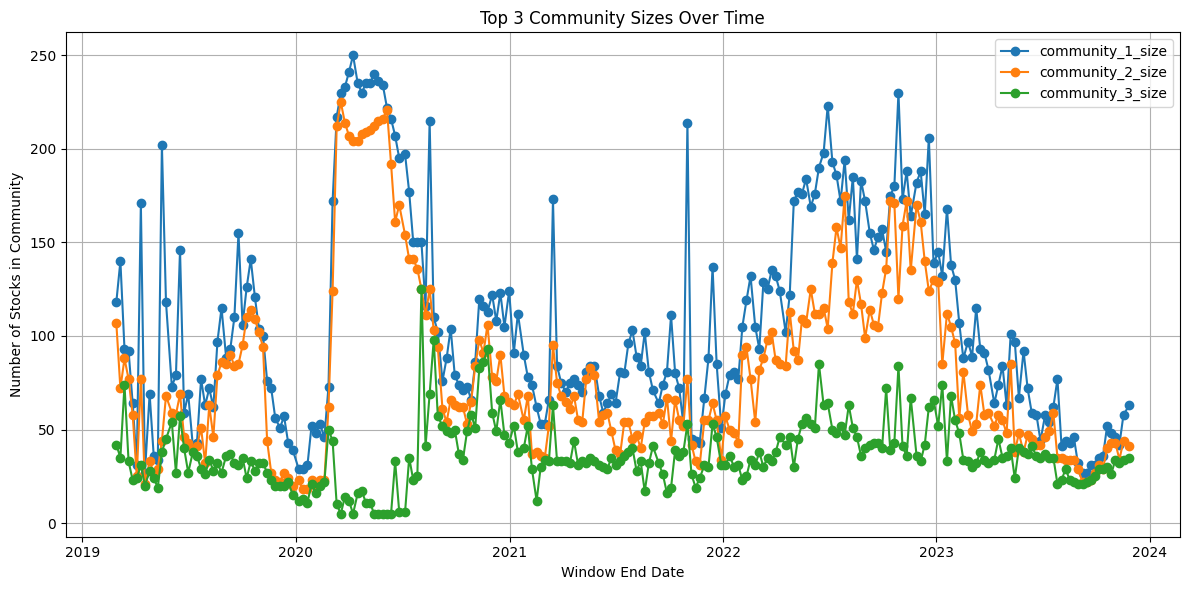

In [10]:
#Collect the top‑3 community sizes for each rolling window
records = []
for start in range(0, len(returns_full) - window_size + 1, step):
    window = returns_full.iloc[start : start + window_size]
    corr_mat = window.corr()

    G = nx.Graph()
    G.add_nodes_from(tickers_full)
    for i, j in itertools.combinations(tickers_full, 2):
        if corr_mat.loc[i, j] > thresh:
            G.add_edge(i, j, weight=corr_mat.loc[i, j])

    communities = list(greedy_modularity_communities(G, weight='weight'))
    sizes = sorted((len(c) for c in communities), reverse=True)
    top3 = sizes[:3] + [None] * (3 - len(sizes))
    end_date = returns_full.index[start + window_size - 1].date()

    records.append({
        'date': end_date,
        'community_1_size': top3[0],
        'community_2_size': top3[1],
        'community_3_size': top3[2]
    })

#Build a DataFrame and set the date index
df_comm = pd.DataFrame(records).set_index('date')

#Show the first few rows as a table
print(df_comm.head())

#Plot the sizes of the 3 largest communities over time
plt.figure(figsize=(12, 6))
for col in ['community_1_size', 'community_2_size', 'community_3_size']:
    plt.plot(df_comm.index, df_comm[col], marker='o', label=col)

plt.title('Top 3 Community Sizes Over Time')
plt.xlabel('Window End Date')
plt.ylabel('Number of Stocks in Community')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#Load and preprocess data
#try:
    #stock_data['Date'] = stock_data['Date'].dt.tz_convert(None)
#except AttributeError:
    #pass

#Pivot and compute returns
pivot_full = stock_data.pivot(index='Date', columns='Company', values='Close')
returns_full = pivot_full.pct_change().iloc[1:].fillna(method='ffill')

#Parameters
tickers_full = returns_full.columns.tolist()
window_size, step, thresh = 60, 5, 0.7

#Compute community assignments per window
dates = []
comm_map = pd.DataFrame(index=tickers_full)
for start in range(0, len(returns_full) - window_size + 1, step):
    window = returns_full.iloc[start:start+window_size]
    corr_mat = window.corr()

    #Build graph
    G = nx.Graph()
    G.add_nodes_from(tickers_full)
    for i, j in itertools.combinations(tickers_full, 2):
        if corr_mat.loc[i, j] > thresh:
            G.add_edge(i, j, weight=corr_mat.loc[i, j])

    #Detect communities and pick top 3
    communities = list(greedy_modularity_communities(G, weight='weight'))
    top3 = sorted(communities, key=lambda c: len(c), reverse=True)[:3]

    #Assign community IDs (0,1,2) or 3 for 'other'
    comm_id = pd.Series(3, index=tickers_full)
    for idx, comm in enumerate(top3):
        comm_id[list(comm)] = idx
    end_date = returns_full.index[start+window_size-1].date()
    date_str = end_date.isoformat()
    dates.append(date_str)
    comm_map[date_str] = comm_id

#Build Sankey diagram data
#Node labels: one per (date, community)
nodes = []
for date in dates:
    for cid in range(4):
        nodes.append(f"{date}_C{cid}")
node_indices = {label: i for i, label in enumerate(nodes)}

sources, targets, values = [], [], []
for i in range(len(dates) - 1):
    d1, d2 = dates[i], dates[i+1]
    for cid1 in range(4):
        for cid2 in range(4):
            src = f"{d1}_C{cid1}"
            tgt = f"{d2}_C{cid2}"
            count = ((comm_map[d1] == cid1) & (comm_map[d2] == cid2)).sum()
            if count > 0:
                sources.append(node_indices[src])
                targets.append(node_indices[tgt])
                values.append(count)

#Plot alluvial diagram
fig = go.Figure(data=go.Sankey(
    node = dict(label=nodes),
    link = dict(source=sources, target=targets, value=values)
))
fig.update_layout(
    title_text="Alluvial Plot: Flow of Stocks Among Top 3 Communities Over Time",
    font_size=10
)
fig.write_html(
    "Alluvial plot: Flow of stocks among top 3 communities over time.html",
    include_plotlyjs="cdn",
    full_html=True
)
fig.show()

<ipython-input-13-455ba11fc51e>:9: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-13-455ba11fc51e>:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-13-455ba11fc51e>:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-13-455ba11fc51e>:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

<ipython-input-14-1713b91a881f>:10: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



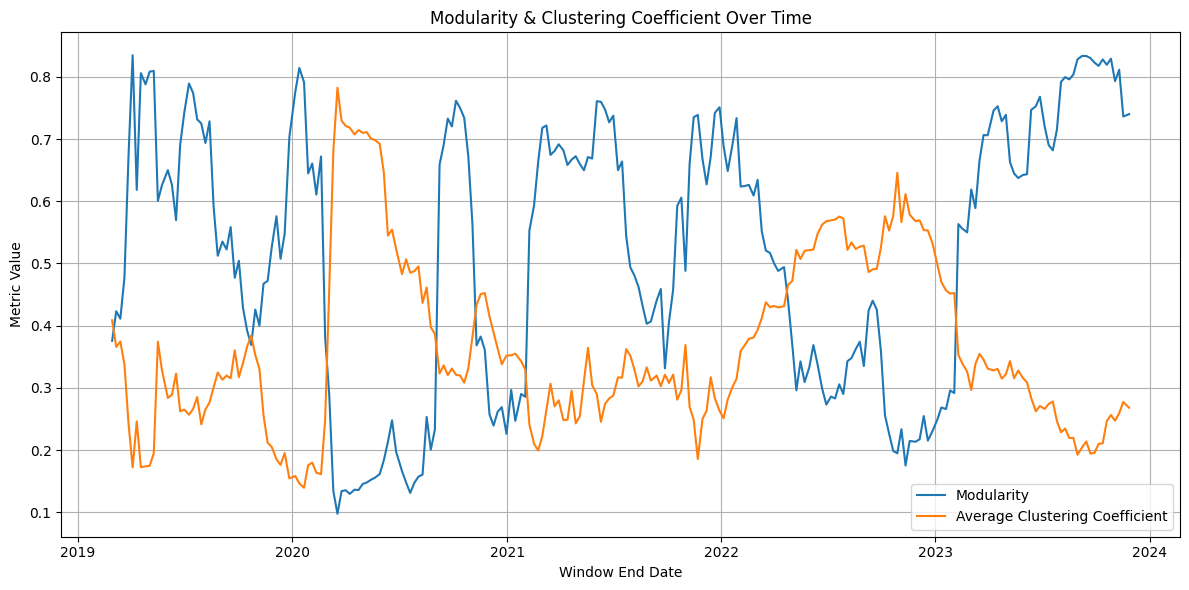

In [14]:
#Load and preprocess data
stock_data = pd.read_csv('/content/stock_details_5_years.csv', parse_dates=['Date'])
try:
    stock_data['Date'] = stock_data['Date'].dt.tz_convert(None)
except AttributeError:
    pass

#Pivot and compute returns
pivot_full = stock_data.pivot(index='Date', columns='Company', values='Close')
returns_full = pivot_full.pct_change().iloc[1:].fillna(method='ffill')

#Parameters for rolling window analysis
tickers_full = returns_full.columns.tolist()
window_size  = 60   # days per window
step         = 5    # shift window by 5 days
thresh       = 0.7  # correlation threshold

#Collect modularity and clustering coefficient over time
dates = []
mod_values = []
clus_values = []

for start in range(0, len(returns_full) - window_size + 1, step):
    window   = returns_full.iloc[start : start + window_size]
    corr_mat = window.corr()

    #Build graph based on correlation threshold
    G = nx.Graph()
    G.add_nodes_from(tickers_full)
    for i, j in itertools.combinations(tickers_full, 2):
        if corr_mat.loc[i, j] > thresh:
            G.add_edge(i, j, weight=corr_mat.loc[i, j])

    #Community detection and metrics
    communities = list(greedy_modularity_communities(G, weight='weight'))
    mod = modularity(G, communities, weight='weight')
    clus = nx.average_clustering(G)

    #Record the end date and metrics
    end_date = returns_full.index[start + window_size - 1]
    dates.append(end_date)
    mod_values.append(mod)
    clus_values.append(clus)

#Plot the metrics over time
plt.figure(figsize=(12, 6))
plt.plot(dates, mod_values, label='Modularity')
plt.plot(dates, clus_values, label='Average Clustering Coefficient')
plt.xlabel('Window End Date')
plt.ylabel('Metric Value')
plt.title('Modularity & Clustering Coefficient Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
